In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import gc
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(f"Using device: {device}")

Using device: cuda


In [3]:
def load_paths(root_dir):
    """Load paths for all land categories"""
    land_paths = []
    print(f"Scanning directory: {root_dir}")
    
    # Process all land categories
    categories = ['agri', 'barrenland', 'grassland', 'urban']
    for category in os.listdir(root_dir):
        if any(land_type in category.lower() for land_type in categories):
            category_path = os.path.join(root_dir, category)
            if not os.path.isdir(category_path):
                continue
                
            # Look for 's2' subdirectories
            s2_path = os.path.join(category_path, 's2')
            if os.path.isdir(s2_path):
                for file in os.listdir(s2_path):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        land_paths.append((os.path.join(s2_path, file), category.lower()))
    
    land_paths = sorted(land_paths)
    
    # Count images per category
    agri_count = sum(1 for _, cat in land_paths if 'agri' in cat)
    barren_count = sum(1 for _, cat in land_paths if 'barrenland' in cat)
    grass_count = sum(1 for _, cat in land_paths if 'grassland' in cat)
    urban_count = sum(1 for _, cat in land_paths if 'urban' in cat)
    
    print(f"Found {len(land_paths)} total images:")
    print(f"- Agricultural land: {agri_count} images")
    print(f"- Barren land: {barren_count} images")
    print(f"- Grassland: {grass_count} images")
    print(f"- Urban land: {urban_count} images")
    
    return [path for path, _ in land_paths]

In [4]:
# Dataset Class
class LandDataset(Dataset):
    def __init__(self, color_paths, img_size=128):
        self.color_paths = color_paths
        self.img_size = img_size
        
    def __len__(self):
        return len(self.color_paths)

    def _rgb_to_lab(self, img_path):
        """Convert RGB image to Lab directly from path"""
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            return np.zeros((self.img_size, self.img_size), dtype=np.float32), \
                   np.zeros((self.img_size, self.img_size, 2), dtype=np.float32)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        img_lab = cv2.resize(img_lab, (self.img_size, self.img_size))
        
        # Split and normalize channels
        L = img_lab[:, :, 0].astype(np.float32)
        a = img_lab[:, :, 1].astype(np.float32)
        b = img_lab[:, :, 2].astype(np.float32)
        
        # Normalization
        L = (L / 50.0) - 1.0
        ab = np.stack((a, b), axis=-1)
        ab = (ab - 128.0) / 128.0
        
        return L, ab

    def __getitem__(self, idx):
        L, ab = self._rgb_to_lab(self.color_paths[idx])
        L_tensor = torch.from_numpy(L).unsqueeze(0).float()
        ab_tensor = torch.from_numpy(ab.transpose(2, 0, 1)).float()
        return L_tensor, ab_tensor, self.color_paths[idx]


In [5]:
# Model Architecture
class SARColorizationModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 16 -> 32
            nn.Conv2d(512, 256, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 32 -> 64
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),  # 64 -> 128
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 2, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)


In [6]:
# Utility Functions
def lab_to_rgb(L, ab):
    """Convert Lab tensors to RGB numpy array"""
    L = L.cpu().numpy().squeeze()
    ab = ab.detach().cpu().numpy().squeeze().transpose(1, 2, 0)
    
    # Denormalize
    L = (L + 1.0) * 50.0
    ab = ab * 128.0 + 128.0
    
    # Clip and convert to uint8
    Lab = np.clip(np.dstack((L, ab)), 0, 255).astype("uint8")
    bgr = cv2.cvtColor(Lab, cv2.COLOR_Lab2BGR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


In [7]:
def compute_metrics(true_rgb, pred_rgb):
    """Compute PSNR and SSIM between true and predicted RGB images"""
    # Convert to grayscale for SSIM
    true_gray = cv2.cvtColor(true_rgb, cv2.COLOR_RGB2GRAY)
    pred_gray = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2GRAY)
    
    # Calculate metrics
    psnr_value = psnr(true_rgb, pred_rgb, data_range=255)
    ssim_value = ssim(true_gray, pred_gray, data_range=255)
    
    return psnr_value, ssim_value


In [8]:
def save_sample_results(sar, true, pred, path, save_dir, metrics=None):
    """Save sample results to disk without matplotlib"""
    # Create directory if needed
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.basename(path)
    
    # Create SAR grayscale image
    sar_normalized = cv2.normalize(sar, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    sar_rgb = cv2.cvtColor(sar_normalized, cv2.COLOR_GRAY2RGB)
    
    # Create combined image (SAR | True | Pred)
    combined = np.hstack((sar_rgb, true, pred))
    
    # Add metrics text if provided
    if metrics:
        psnr_val, ssim_val = metrics
        text = f"PSNR: {psnr_val:.2f} dB, SSIM: {ssim_val:.4f}"
        cv2.putText(combined, text, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Save image
    output_path = os.path.join(save_dir, f"result_{filename}")
    cv2.imwrite(output_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))
    return output_path


In [9]:
# Training function
def train_model(train_loader, num_epochs=1):
    model = SARColorizationModel().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("\nStarting Training...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()
        
        for batch_idx, (L, ab, _) in enumerate(train_loader):
            L, ab = L.to(device), ab.to(device)
            
            optimizer.zero_grad()
            pred_ab = model(L)
            loss = criterion(pred_ab, ab)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Clear memory
            del L, ab, pred_ab, loss
            torch.cuda.empty_cache()
            gc.collect()
            
            if batch_idx % 50 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                print(f"Batch {batch_idx}/{len(train_loader)} | Loss: {avg_loss:.4f}")
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Time: {time.time()-start_time:.1f}s")
    
    print("✅ Training completed.")
    return model


In [10]:
# Evaluation function with disk-saving
def evaluate_model(model, test_loader, num_samples=5, save_dir="sample_results"):
    model.eval()
    total_psnr = 0.0
    total_ssim = 0.0
    count = 0
    sample_paths = []
    
    # Create output directory
    os.makedirs(save_dir, exist_ok=True)
    
    print(f"\nEvaluating model on test set and saving results to {save_dir}...")
    with torch.no_grad():
        for batch_idx, (L, ab, paths) in enumerate(test_loader):
            L, ab = L.to(device), ab.to(device)
            pred_ab = model(L)
            
            # Process each image in the batch
            for i in range(L.size(0)):
                # Convert to numpy arrays
                sar_img = L[i].cpu().squeeze().numpy()
                true_rgb = lab_to_rgb(L[i], ab[i])
                pred_rgb = lab_to_rgb(L[i], pred_ab[i])
                
                # Compute metrics
                psnr_value, ssim_value = compute_metrics(true_rgb, pred_rgb)
                total_psnr += psnr_value
                total_ssim += ssim_value
                count += 1
                
                # Save sample results
                if len(sample_paths) < num_samples:
                    metrics = (psnr_value, ssim_value)
                    saved_path = save_sample_results(
                        sar_img, true_rgb, pred_rgb, 
                        paths[i], save_dir, metrics
                    )
                    sample_paths.append(saved_path)
            
            # Clear memory
            del L, ab, pred_ab
            torch.cuda.empty_cache()
            gc.collect()
            
            if batch_idx % 10 == 0:
                print(f"Processed {count} images...")
    
    # Calculate average metrics
    avg_psnr = total_psnr / count
    avg_ssim = total_ssim / count
    
    print("\nEvaluation Metrics:")
    print(f"Average PSNR: {avg_psnr:.2f} dB (higher is better)")
    print(f"Average SSIM: {avg_ssim:.4f} (higher is better)")
    
    # Save metrics to file
    with open(os.path.join(save_dir, "metrics.txt"), "w") as f:
        f.write(f"Average PSNR: {avg_psnr:.2f} dB\n")
        f.write(f"Average SSIM: {avg_ssim:.4f}\n")
        f.write(f"Total images evaluated: {count}\n")
    
    print(f"\nSaved {len(sample_paths)} sample results to {save_dir}")
    return avg_psnr, avg_ssim, sample_paths


In [12]:
# Main execution
if __name__ == "__main__":
    # Configuration
    DATA_DIR = r"D:\My Disk\coding\v_2"
    IMG_SIZE = 128
    BATCH_SIZE = 16
    NUM_EPOCHS = 1
    TEST_SIZE = 0.2 # 10% for testing
    SAMPLE_DIR = "sample_results"
    
    # Load paths for barren land only
    color_paths = load_paths(DATA_DIR)
    if len(color_paths) == 0:
        raise ValueError("No land images found!")

    # Split dataset
    split_idx = int(len(color_paths) * (1 - TEST_SIZE))
    train_paths = color_paths[:split_idx]
    test_paths = color_paths[split_idx:]
    
    print(f"\nDataset Statistics:")
    print(f"Total land images: {len(color_paths)}")
    print(f"Training images: {len(train_paths)}")
    print(f"Test images: {len(test_paths)}")
    
    # Create datasets and loaders
    train_dataset = LandDataset(train_paths, IMG_SIZE)  # Updated class name
    test_dataset = LandDataset(test_paths, IMG_SIZE)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=min(16, len(test_paths)), shuffle=False)
    
    # Train model
    model = train_model(train_loader, NUM_EPOCHS)
    
    # Save model with descriptive name
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    model_path = f"land_colorization_model_{timestamp}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_path}")
    
    # Create category-specific sample directories
    sample_dir = f"sample_results_{timestamp}"
    
    # Evaluate model and save samples
    avg_psnr, avg_ssim, sample_paths = evaluate_model(
        model, test_loader, 
        num_samples=20,  # Increased samples to cover all categories
        save_dir=sample_dir
    )
    
    print(f"\nFinal Metrics:")
    print(f"PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")
    print(f"Sample results saved in {SAMPLE_DIR} directory")
    print("\n✅ All operations completed successfully!")

Scanning directory: D:\My Disk\coding\v_2
Found 16000 total images:
- Agricultural land: 4000 images
- Barren land: 4000 images
- Grassland: 4000 images
- Urban land: 4000 images

Dataset Statistics:
Total land images: 16000
Training images: 12800
Test images: 3200

Starting Training...
Batch 0/800 | Loss: 0.0117
Batch 50/800 | Loss: 0.0155
Batch 100/800 | Loss: 0.0122
Batch 150/800 | Loss: 0.0112
Batch 200/800 | Loss: 0.0107
Batch 250/800 | Loss: 0.0104
Batch 300/800 | Loss: 0.0100
Batch 350/800 | Loss: 0.0098
Batch 400/800 | Loss: 0.0097
Batch 450/800 | Loss: 0.0096
Batch 500/800 | Loss: 0.0095
Batch 550/800 | Loss: 0.0094
Batch 600/800 | Loss: 0.0093
Batch 650/800 | Loss: 0.0093
Batch 700/800 | Loss: 0.0092
Batch 750/800 | Loss: 0.0092
Epoch [1/1] | Loss: 0.0091 | Time: 445.9s
✅ Training completed.
Model saved as land_colorization_model_20250530_231610.pth

Evaluating model on test set and saving results to sample_results_20250530_231610...
Processed 16 images...
Processed 176 image

In [13]:
def show_sample_batch(dataloader):
    """Display a sample batch of images with filenames: Original L channel, True color, and Predicted color"""
    # Get a batch
    L, ab, paths = next(iter(dataloader))
    
    # Move to device and get predictions
    L, ab = L.to(device), ab.to(device)
    model.eval()
    with torch.no_grad():
        pred_ab = model(L)
    
    # Take first 4 images from batch
    n_samples = min(4, L.size(0))
    fig, axes = plt.subplots(n_samples, 3, figsize=(12, 3*n_samples))
    
    for idx in range(n_samples):
        # Get filename from path
        filename = os.path.basename(paths[idx])
        
        # Original L channel
        axes[idx, 0].imshow(L[idx].cpu().squeeze(), cmap='gray')
        axes[idx, 0].set_title(f'L Channel (Input)\n{filename}')
        
        # True color
        true_rgb = lab_to_rgb(L[idx], ab[idx])
        axes[idx, 1].imshow(true_rgb)
        axes[idx, 1].set_title(f'True Color\n{filename}')
        
        # Predicted color
        pred_rgb = lab_to_rgb(L[idx], pred_ab[idx])
        axes[idx, 2].imshow(pred_rgb)
        axes[idx, 2].set_title(f'Predicted Color\n{filename}')
        
        # Remove axes
        for ax in axes[idx]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print sample metrics with filename
    psnr_val, ssim_val = compute_metrics(true_rgb, pred_rgb)
    print(f"\nSample Metrics for {os.path.basename(paths[-1])}:")
    print(f"PSNR: {psnr_val:.2f} dB")
    print(f"SSIM: {ssim_val:.4f}")

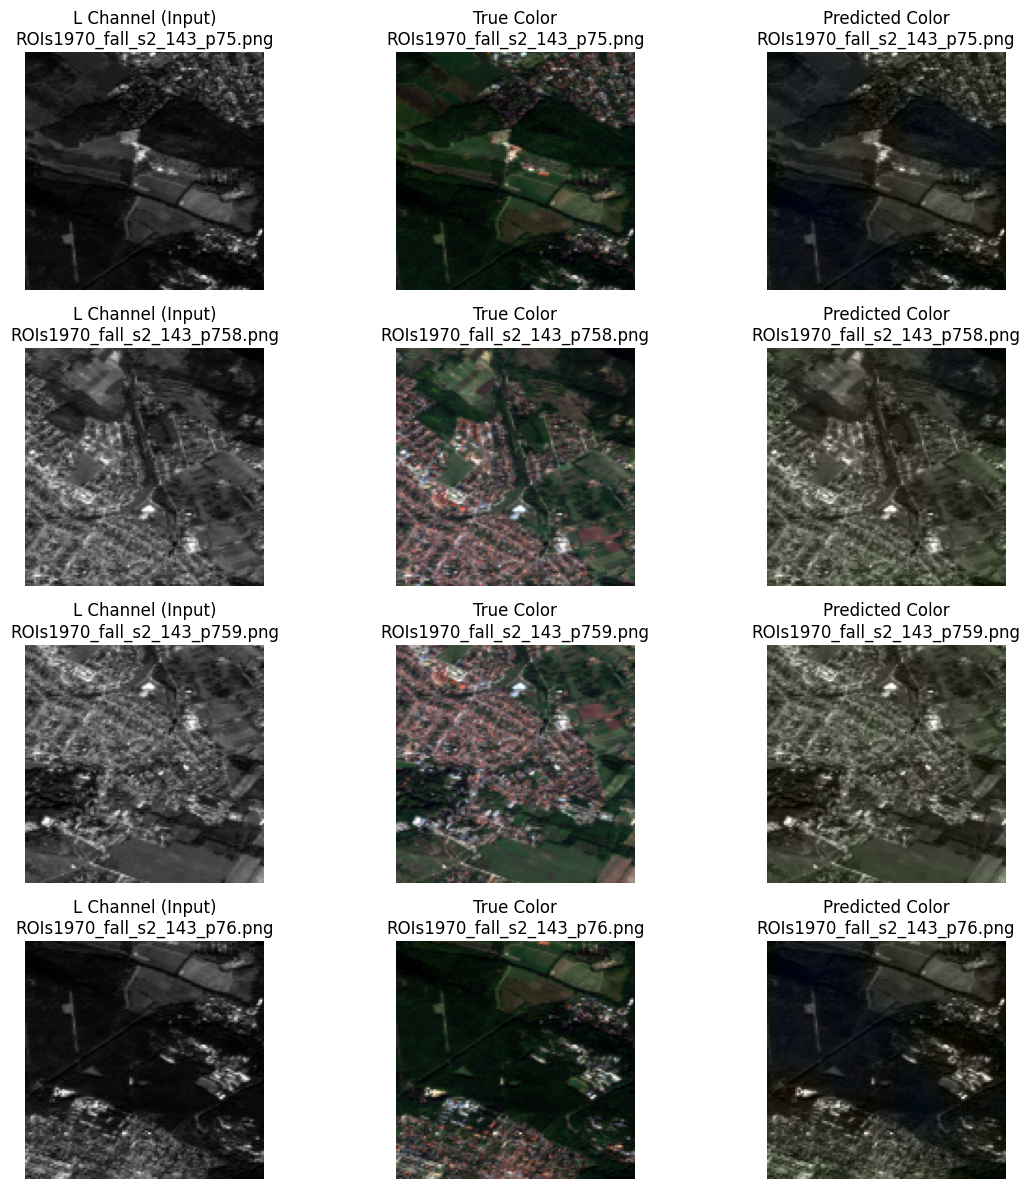


Sample Metrics for ROIs1970_fall_s2_143_p775.png:
PSNR: 29.64 dB
SSIM: 0.9920


In [14]:
# Run this in a new cell after training
show_sample_batch(test_loader)